# Options Trading Strategy Backtesting Analysis

This notebook analyzes option trading opportunities based on probability predictions and distance from at-the-money (ATM) strikes. 

## Overview
- **Data Source**: Option model results with probability predictions
- **Strategy**: Trade options when probability exceeds statistical thresholds
- **Risk Management**: Fixed risk per trade ($5,000)
- **Analysis Period**: Multi-year backtesting with year-over-year comparison

## Key Metrics
- **Distance from ATM**: Measured in percentage terms 
- **Probability Threshold**: Mean + 1 standard deviation per distance bucket
- **Return Calculation**: Entry at close vs exit at 15:30 next day
- **Portfolio Management**: $100,000 starting capital, position sizing based on risk

In [1]:
# Import required libraries for data analysis
import pandas as pd
import numpy as np

In [2]:
# Load the option model results CSV file
# This contains historical option data with probability predictions
df = pd.read_csv('/home/mrmath/Downloads/vwap_model_/option_model/option_model_results.csv')
df

,option,timestamp,open,high,low,close,volume,datetime,close_spy,ATM_strike,...,seconds_since_open,seconds_until_close,option_ret_from_open,year,pct_gain_15_30,side_aware_dist_from_ATM,side_int,prediction,probability,train_years
0,O:SPY230103C00376000,1672763400000,3.98,3.98,3.98,3.98,10,2023-01-03 11:30:00-05:00,379.4900,379,...,7200.0,16200.0,0.0,2023,0.271357,-0.007916,1,0,0.346485,[np.int32(2022)]
1,O:SPY230103C00376000,1672763700000,3.69,3.91,3.69,3.89,5,2023-01-03 11:35:00-05:00,379.6400,379,...,7500.0,15900.0,-9.0,2023,0.300771,-0.007916,1,0,0.445777,[np.int32(2022)]
2,O:SPY230103C00376000,1672764000000,3.79,3.79,3.60,3.60,6,2023-01-03 11:40:00-05:00,379.1000,379,...,7800.0,15600.0,-38.0,2023,0.405556,-0.007916,1,0,0.453138,[np.int32(2022)]
3,O:SPY230103C00376000,1672764300000,3.23,3.28,3.15,3.28,81,2023-01-03 11:45:00-05:00,379.1080,379,...,8100.0,15300.0,-70.0,2023,0.542683,-0.007916,1,0,0.378873,[np.int32(2022)]
4,O:SPY230103C00376000,1672764600000,3.00,3.36,3.00,3.15,113,2023-01-03 11:50:00-05:00,378.9821,378,...,8400.0,15000.0,-83.0,2023,0.606349,-0.005291,1,0,0.408360,[np.int32(2022)]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168985,O:SPY251231P00695000,1767210600000,10.69,10.98,10.69,10.98,6,2025-12-31 14:50:00-05:00,684.1050,684,...,19200.0,4200.0,59.0,2025,0.183971,-0.016082,-1,0,0.433703,"[np.int32(2022), np.int32(2023), np.int32(2024)]"
1168986,O:SPY251231P00695000,1767211800000,11.77,11.77,11.77,11.77,1,2025-12-31 15:10:00-05:00,683.2400,683,...,20400.0,3000.0,138.0,2025,0.104503,-0.017570,-1,0,0.394757,"[np.int32(2022), np.int32(2023), np.int32(2024)]"
1168987,O:SPY251231P00696000,1767207900000,10.03,10.04,10.03,10.04,2,2025-12-31 14:05:00-05:00,686.0050,686,...,16500.0,6900.0,0.0,2025,0.345618,-0.014577,-1,1,0.528504,"[np.int32(2022), np.int32(2023), np.int32(2024)]"
1168988,O:SPY251231P00697000,1767200400000,11.70,11.72,11.52,11.62,11,2025-12-31 12:00:00-05:00,685.2900,685,...,9000.0,14400.0,0.0,2025,0.302926,-0.017518,-1,1,0.588949,"[np.int32(2022), np.int32(2023), np.int32(2024)]"


In [3]:
# Round to the nearest 0.5% and clip extreme values to avoid sparse data
df['dist_otm_pct_rounded'] = (
    (df['side_aware_dist_from_ATM'] * 100).round(1) // 0.5 * 0.5
).clip(lower=-3, upper=3)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert('America/New_York')

In [5]:
ret_df = df.sort_values(
    ['dist_otm_pct_rounded', 'datetime', 'side']
)

# Extract trading date
ret_df['date'] = ret_df['datetime'].dt.date

# Keep first trade per (OTM, Call/Put, Day)
filtered = (
    ret_df
    .groupby(['dist_otm_pct_rounded', 'side', 'date'])
    .first()
    .reset_index()
)



/tmp/ipykernel_38376/3141436535.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(pnl_curves))


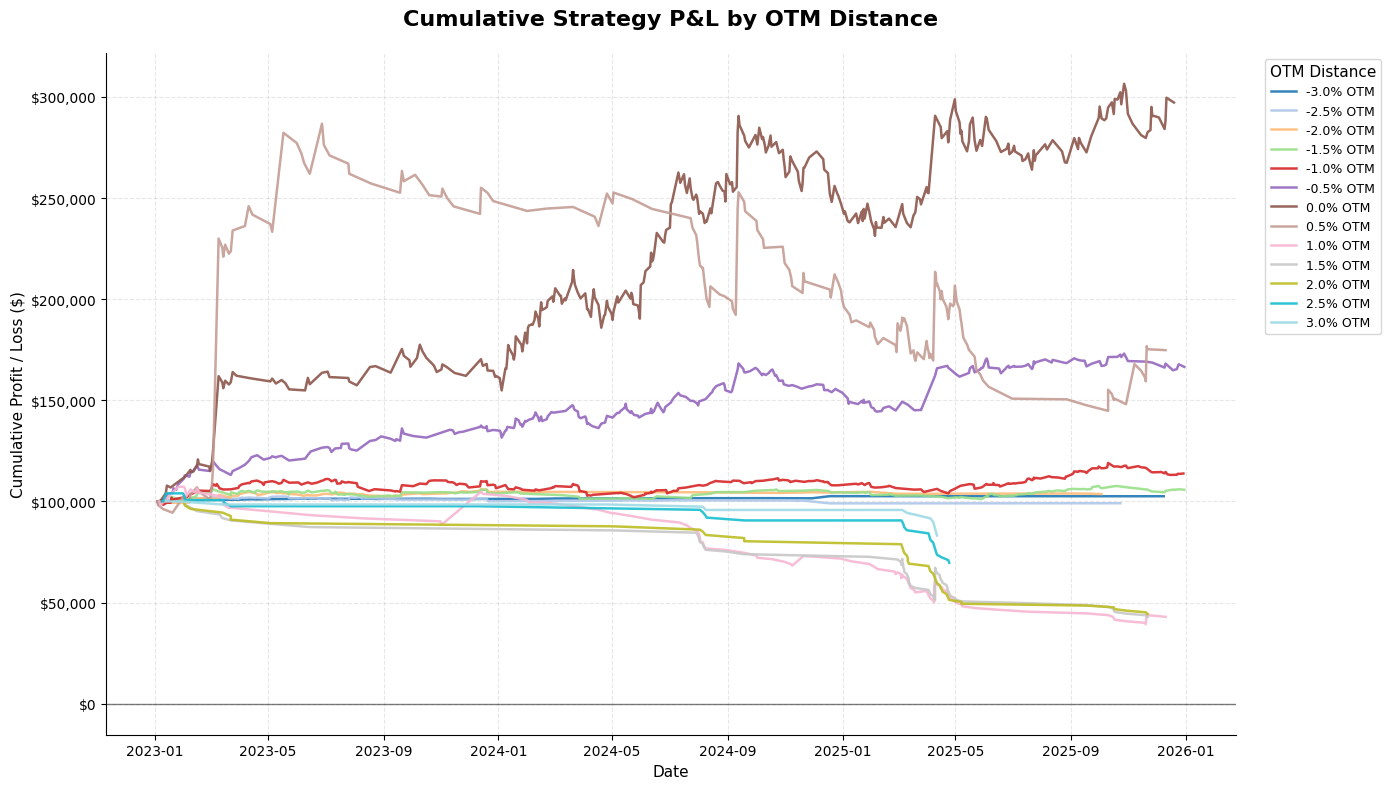

In [6]:
# We'll store the portfolio curves here
pnl_curves = {}

# Global Simulation Settings
STARTING_CASH = 100_000
RISK_PCT = 0.02

for dist, g in filtered.groupby('dist_otm_pct_rounded'):
    # 1. Sort and Pre-calculate probability filters
    g = g.sort_values('datetime').copy()
    g['expanding_mean_proba'] = g['probability'].expanding().mean()
    g['expanding_std_proba'] = g['probability'].expanding().std()
    
    # Filter valid trades based on your probability edge
    valid_mask = (g['close_in_cents'] > 0) & \
                 (g['price_at_15_30'] > 0) & \
                 (g['probability'] > g['expanding_mean_proba'] + 1 * g['expanding_std_proba'])
    g = g[valid_mask].copy()
    
    if g.empty:
        continue

    # --- RESET BANKROLL FOR EACH GROUP ---
    current_balance = STARTING_CASH
    # Initialize history with the starting balance at T-1
    balance_history = {g['datetime'].min() - pd.Timedelta(days=1): STARTING_CASH}
    
    # 2. Iterate through each unique trading timestamp
    daily_groups = g.groupby('datetime')
    
    for dt, day_data in daily_groups:
        # Calculate 2% of the current bankroll for today's total allocation
        daily_allocation = current_balance * RISK_PCT
        
        # If multiple trades exist at this time, split the 2% across them
        num_trades = len(day_data)
        alloc_per_trade = daily_allocation / num_trades
        
        total_day_pnl = 0
        
        for _, trade in day_data.iterrows():
            entry_price = trade['close_in_cents'] / 100
            exit_price = trade['price_at_15_30'] / 100
            
            # Cost of 1 contract (100 shares)
            contract_cost = entry_price * 100
            
            # Calculate number of contracts based on allocated $ for this trade
            if contract_cost > 0:
                num_contracts = int(alloc_per_trade / contract_cost)
            else:
                num_contracts = 0
                
            # Profit/Loss for this specific trade
            trade_pnl = num_contracts * (exit_price - entry_price) * 100
            total_day_pnl += trade_pnl
            
        # Update the bankroll for the next day/trade
        current_balance += total_day_pnl
        balance_history[dt] = current_balance
        
    # Store the resulting balance curve
    pnl_curves[dist] = pd.Series(balance_history)



import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 1. Use 'tab20' to ensure every single line has a unique, distinct color
colors = plt.cm.get_cmap('tab20', len(pnl_curves))

plt.figure(figsize=(14, 8))
ax = plt.gca()

# 2. Plot with unique colors
for i, dist in enumerate(sorted(pnl_curves.keys())):
    curve = pnl_curves[dist]
    ax.plot(
        curve.index, 
        curve.values, 
        label=f"{dist}% OTM", 
        color=colors(i), 
        linewidth=1.8,
        alpha=0.9
    )

# 3. Optimize the Legend
# ncol=2 splits the legend into two columns to prevent it from being too tall
plt.legend(
    title="OTM Distance", 
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    fontsize=9,
    title_fontsize=11,
    frameon=True,
    shadow=False,
    ncol=1 # Change to 2 if you want to save vertical space
)

# 4. Refined Aesthetics
plt.title("Cumulative Strategy P&L by OTM Distance", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Cumulative Profit / Loss ($)", fontsize=11)
plt.xlabel("Date", fontsize=11)

# Ensure the zero line is distinct but not distracting
plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Format Y-axis for currency
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

# Lighter grid for a cleaner look
plt.grid(True, linestyle='--', alpha=0.3)

# Remove the box spines for a modern feel
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()